In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu

# 1. Аналитика

In [2]:
df1 = pd.read_csv ('/datasets/query_1.csv')
df2 = pd.read_csv ('/datasets/query_3.csv')
df3 = pd.read_csv ('/datasets/query_last.csv')

In [3]:
def statistic (df):
    print(df.head(10)),
    print("="*40),
    print(df.info()),
    print("="*40),
    print(df.describe())

In [4]:
statistic (df1)

                 model  flights_amount
0      Airbus A319-100             607
1      Airbus A321-200             960
2       Boeing 737-300             630
3       Boeing 767-300             600
4       Boeing 777-300             300
5   Bombardier CRJ-200            4446
6   Cessna 208 Caravan            4557
7  Sukhoi SuperJet-100            4185
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes
None
       flights_amount
count        8.000000
mean      2035.625000
std       1965.203947
min        300.000000
25%        605.250000
50%        795.000000
75%       4250.250000
max       4557.000000


In [5]:
statistic (df2)

           city  average_flights
0        Абакан         3.870968
1       Анадырь         1.000000
2         Анапа         2.161290
3   Архангельск         5.354839
4     Астрахань         2.451613
5       Барнаул         2.612903
6      Белгород         6.000000
7    Белоярский         2.000000
8  Благовещенск         1.000000
9        Братск         1.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB
None
       average_flights
count       101.000000
mean          5.494189
std          13.119790
min           1.000000
25%           2.000000
50%           3.000000
75%           5.870968
max         129.774194


In [6]:
df2.sort_values(by='average_flights', ascending=False)

,city,average_flights
43,Москва,129.774194
70,Санкт-Петербург,31.161290
54,Новосибирск,17.322581
33,Красноярск,11.580645
20,Екатеринбург,11.322581
...,...,...
22,Ижевск,1.000000
65,Петропавловск-Камчатский,1.000000
31,Комсомольск-на-Амуре,1.000000
58,Нягань,1.000000


In [7]:
df2['average_flights'] = df2['average_flights'].astype('int')

#### После осмотра данных можно сказать что они вполне коректны, Москва и Санкт-Петербург имеют самое большое среднее количество рейсов (это узловые города для междугородних/международных перелетов), а среди моделей самолетов доминируют сразу три модели, что резко снижает шанс того, что это выбросы.   
#### Однако среднее количество рейсов - это целое число, поэтому тип данных переведен в целочисленный.

In [8]:
# Выберем топ 10 городов по колличеству рейсов
df_top = df2.sort_values(by='average_flights', ascending=False).head(10).reset_index(drop=True)
df_top

,city,average_flights
0,Москва,129
1,Санкт-Петербург,31
2,Новосибирск,17
3,Екатеринбург,11
4,Красноярск,11
5,Пермь,10
6,Ростов-на-Дону,10
7,Брянск,10
8,Ульяновск,9
9,Советский,9


#### Как видно, в среднем в аэропорты городов ежедневно прибывают от 9 до 129 рейсов. Москва, являясь столицей и самым крупным международным портом, многократно превосходит остальные аэропорты по посещаемости.

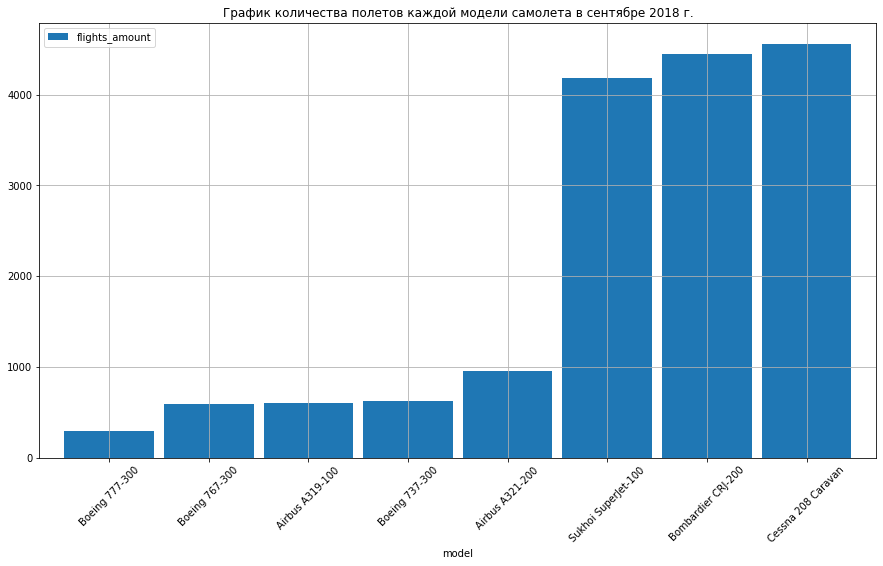

In [9]:
df1.sort_values(by='flights_amount').plot(
    kind='bar', 
    x='model', 
    y='flights_amount', 
    figsize=(15,8), 
    title='График количества полетов каждой модели самолета в сентябре 2018 г.', 
    rot=45, 
    width = 0.9,
    grid=True
)

#### из данного графика видно, что модели самолетов Bombardier CRJ-200, Cessna 208 Caravan, Sukhoi SuperJet-100 совершают в 4 раза больше перелетов, чем остальные из представленных моделей. Из этого можно сделать вывод, что эти самолеты при расширении парка летательных средств могут оказаться наиболее выгодными для приобретения.

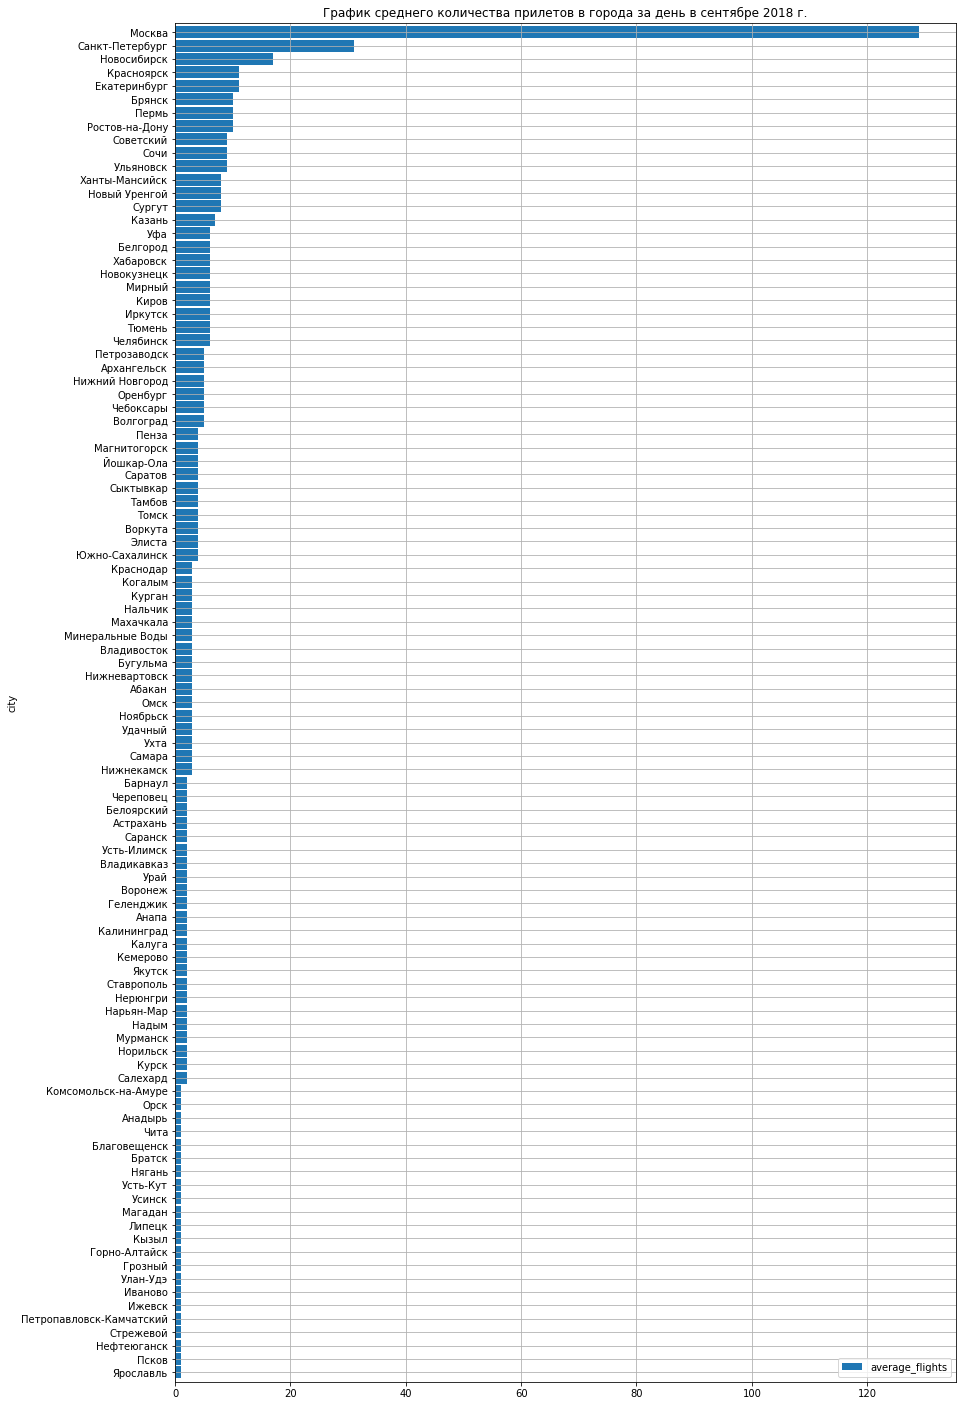

In [10]:
df2.sort_values(by='average_flights').plot(
    kind='barh', 
    x='city', 
    y='average_flights', 
    figsize=(14,25), 
    title='График среднего количества прилетов в города за день в сентябре 2018 г.', 
    rot=0, 
    width = 0.9,
    grid=True
)

#### По графику видно, что большая часть аэропортов России в сутки принимает крайне малое количество воздушных судов и вся основная часть авиаперелетов происходит через Санкт-Петебург и Москву, т.к. они являются крупными туристическими и международными портами.

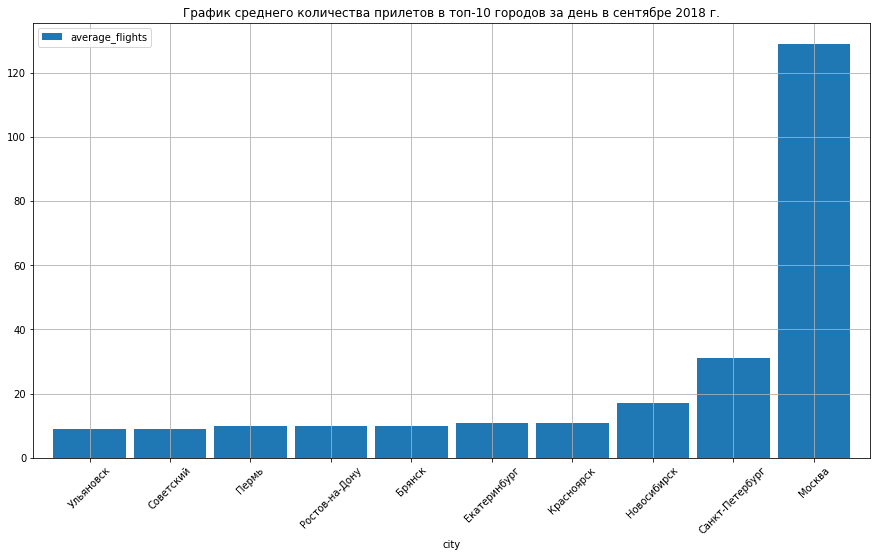

In [11]:
df_top.sort_values(by='average_flights').plot(
    kind='bar', 
    x='city', 
    y='average_flights', 
    figsize=(15,8), 
    title='График среднего количества прилетов в топ-10 городов за день в сентябре 2018 г.', 
    rot=45, 
    width = 0.9,
    grid=True
)

#### более детальное рассмотрение предыдущего графика показывает, что даже среди топ-10 городов по средним прилетам в сутки основная их часть имеет лишь ~10 рейсов, что почти в 13 раз меньше, чем в столице.

# 2. Проверка гипотезы 

#### подготовим данные для проверки гипотезы.   
#### Очень мало данных для того, чтобы считать тесты точными, но т.к. это учебное задание, то предположим что данных все-таки достаточно и тесты верны.

In [12]:
column = ['ticket_amount']
alpha = .05

In [13]:
festival = df3.dropna()
no_festival = df3.query("festival_week.isnull()")

In [14]:
display(festival,
        no_festival)

,week_number,ticket_amount,festival_week,festival_name
0,30,43568,30.0,Park Live
1,31,51034,31.0,Пикник Афиши
6,36,51386,36.0,Видфест


,week_number,ticket_amount,festival_week,festival_name
2,32,51675,NaN,NaN
3,33,51378,NaN,NaN
4,34,51492,NaN,NaN
5,35,51360,NaN,NaN
7,37,51670,NaN,NaN
8,38,51518,NaN,NaN
9,39,51623,NaN,NaN


#### проверим распределение нашей савокупности на нормальность распределения для принятия решения, какой тест использовать для проверки гипотез. 

#### Нулевая гипотеза в данном случае состоит в том, что данные распределены нормально.

In [15]:
k2, p = stats.normaltest(np.array(df3[column]))
if p < alpha: 
    print("p =", p)
    print("Отвергаем нулевую гипотезу")
else:
    print("p =", p)
    print("Не получилось отвергнуть нулевую гипотезу")

p = [7.80452769e-07]
Отвергаем нулевую гипотезу


/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


#### Раз данные распределены не нормально, то для проверки гипотез мы будем использовать непараметрический U-тест (Манна-Уитни)

#### Как принято, наша нулевая гипотеза состоит в том, что средние двух наших выборок не отличаются друг от друга. Следовательно наша альтернативная гипотеза состоит в том, что они отличаются.

In [16]:
stat, results = mannwhitneyu(
    np.array(festival[column]), 
    np.array(no_festival[column])
)

print('p-value:', results)

if (results < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.03412374418900064
Отвергаем нулевую гипотезу


#### по результатам U - теста мы можем утверждать, что средний спрос на билеты во время фестивалей отличается от среднего спроса на билеты в обычное время, т.к. нулевую гипотезу мы отвергли.

### ВЫВОД:
В данной работе мы проанализировали, различается ли количество рейсов, которые делают самолеты в зависимости от модели, или же авиакомпаниии в равной степени пользуются всеми видами воздушных судов. Так же анализировали в каких городах, в среднем, больше рейсов за месяц, высказывали предположения, почему это так. Так же в ходе работы дали ответ на вопрос:"Отличается ли средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время" использовав для этого статистические тесты, а именно тест для проверки нашего распределения выборки и, исходя из его показателей, выбирали статистический тест для проверки равности средних наших савокупностей.  
#### Подведем итоги:
- у авиакомпаний есть предпочтения по выбору моделей самолетов для рейсов, так модели Bombardier CRJ-200, Cessna 208 Caravan, Sukhoi SuperJet-100 в 4 раза популярнее остальных.  
- самое большое количество рейсов в Москве и Санкт-Петербурге, что неудивительно - это огромные международные авиапорты, города являются узловыми для большей части перелетов. Так же там регулярно проходят большие культурные мероприятия, поэтому поток туристов там самый большой.  
- в ходе работы был дан ответ на вопрос о равности спроса на билеты во время фестивалей и в обычные дни - непараметрический U-тест Манна-Уитни помог отвергнуть эту гипотезу - спрос различается.